## Imports

In [20]:
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal
from mne import channels, evoked, create_info
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import mneflow
import scipy.signal as sl
from typing import Optional
import scipy as sp
from mneflow.layers import LFTConv, DeMixing, Dense
from tensorflow.keras.layers import Dropout

def eigencentrality(matrix):
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    eigencentrality = eigenvectors[:,0]
    return eigencentrality

## Original SimpleNet class

In [21]:
class SimpleNet(mneflow.models.LFCNN):
    def __init__(self, Dataset, specs=None):
        if specs is None:
            specs=dict()
        super().__init__(Dataset, specs)

    def build_graph(self):
        self.dmx = DeMixing(size=self.specs['n_latent'], nonlin=tf.identity,
                            axis=3, specs=self.specs)
        self.dmx_out = self.dmx(self.inputs)

        self.tconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=tf.identity,
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )
        self.tconv_out = self.tconv(self.dmx_out)

        self.envconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=self.specs['nonlin'],
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )

        self.envconv_out = self.envconv(self.tconv_out)
        self.pool = lambda X: X[:, :, ::self.specs['pooling'], :]

        self.pooled = self.pool(self.envconv_out)

        dropout = Dropout(
            self.specs['dropout'],
            noise_shape=None
        )(self.pooled)

        self.fin_fc = Dense(size=self.out_dim, nonlin=tf.identity,
                            specs=self.specs)

        y_pred = self.fin_fc(dropout)

        return y_pred

    def compute_patterns(self, data_path=None, *, output='patterns'):

        if not data_path:
            print("Computing patterns: No path specified, using validation dataset (Default)")
            ds = self.dataset.val
        elif isinstance(data_path, str) or isinstance(data_path, (list, tuple)):
            ds = self.dataset._build_dataset(
                data_path,
                split=False,
                test_batch=None,
                repeat=True
            )
        elif isinstance(data_path, mneflow.data.Dataset):
            if hasattr(data_path, 'test'):
                ds = data_path.test
            else:
                ds = data_path.val
        elif isinstance(data_path, tf.data.Dataset):
            ds = data_path
        else:
            raise AttributeError('Specify dataset or data path.')

        X, y = [row for row in ds.take(1)][0]

        self.out_w_flat = self.fin_fc.w.numpy()
        self.out_weights = np.reshape(
            self.out_w_flat,
            [-1, self.dmx.size, self.out_dim]
        )
        self.out_biases = self.fin_fc.b.numpy()
        self.feature_relevances = self.componentwise_loss(X, y)
        self.branchwise_loss(X, y)

        # compute temporal convolution layer outputs for vis_dics
        tc_out = self.pool(self.tconv(self.dmx(X)).numpy())

        # compute data covariance
        X = X - tf.reduce_mean(X, axis=-2, keepdims=True)
        X = tf.transpose(X, [3, 0, 1, 2])
        X = tf.reshape(X, [X.shape[0], -1])
        self.dcov = tf.matmul(X, tf.transpose(X))

        # get spatial extraction fiter weights
        demx = self.dmx.w.numpy()

        kern = np.squeeze(self.tconv.filters.numpy()).T

        X = X.numpy().T
        if 'patterns' in output:
            if 'old' in output:
                self.patterns = np.dot(self.dcov, demx)
            else:
                patterns = []
                X_filt = np.zeros_like(X)
                for i_comp in range(kern.shape[0]):
                    for i_ch in range(X.shape[1]):
                        x = X[:, i_ch]
                        X_filt[:, i_ch] = np.convolve(x, kern[i_comp, :], mode="same")
                    patterns.append(np.cov(X_filt.T) @ demx[:, i_comp])
                self.patterns = np.array(patterns).T
                self.lat_tcs_filt = np.dot(demx.T, X_filt.T)
        else:
            self.patterns = demx

        self.lat_tcs = np.dot(demx.T, X.T)

        del X

        #  Temporal conv stuff
        self.filters = kern.T
        self.tc_out = np.squeeze(tc_out)
        self.corr_to_output = self.get_output_correlations(y)

    def plot_patterns(
        self, sensor_layout=None, sorting='l2', percentile=90,
        scale=False, class_names=None, info=None
    ):
        order, ts = self._sorting(sorting)
        self.uorder = order.ravel()
        l_u = len(self.uorder)
        if info:
            info.__setstate__(dict(_unlocked=True))
            info['sfreq'] = 1.
            self.fake_evoked = evoked.EvokedArray(self.patterns, info, tmin=0)
            if l_u > 1:
                self.fake_evoked.data[:, :l_u] = self.fake_evoked.data[:, self.uorder]
            elif l_u == 1:
                self.fake_evoked.data[:, l_u] = self.fake_evoked.data[:, self.uorder[0]]
            self.fake_evoked.crop(tmax=float(l_u))
            if scale:
                _std = self.fake_evoked.data[:, :l_u].std(0)
                self.fake_evoked.data[:, :l_u] /= _std
        elif sensor_layout:
            lo = channels.read_layout(sensor_layout)
            info = create_info(lo.names, 1., sensor_layout.split('-')[-1])
            orig_xy = np.mean(lo.pos[:, :2], 0)
            for i, ch in enumerate(lo.names):
                if info['chs'][i]['ch_name'] == ch:
                    info['chs'][i]['loc'][:2] = (lo.pos[i, :2] - orig_xy)/3.
                    #info['chs'][i]['loc'][4:] = 0
                else:
                    print("Channel name mismatch. info: {} vs lo: {}".format(
                        info['chs'][i]['ch_name'], ch))

            self.fake_evoked = evoked.EvokedArray(self.patterns, info)

            if l_u > 1:
                self.fake_evoked.data[:, :l_u] = self.fake_evoked.data[:, self.uorder]
            elif l_u == 1:
                self.fake_evoked.data[:, l_u] = self.fake_evoked.data[:, self.uorder[0]]
            self.fake_evoked.crop(tmax=float(l_u))
            if scale:
                _std = self.fake_evoked.data[:, :l_u].std(0)
                self.fake_evoked.data[:, :l_u] /= _std
        else:
            raise ValueError("Specify sensor layout")


        if np.any(self.uorder):
            nfilt = max(self.out_dim, 8)
            nrows = max(1, l_u//nfilt)
            ncols = min(nfilt, l_u)
            f, ax = plt.subplots(nrows, ncols, sharey=True)
            plt.tight_layout()
            f.set_size_inches([16, 3])
            ax = np.atleast_2d(ax)

            for ii in range(nrows):
                fake_times = np.arange(ii * ncols,  (ii + 1) * ncols, 1.)
                vmax = np.percentile(self.fake_evoked.data[:, :l_u], 95)
                self.fake_evoked.plot_topomap(
                    times=fake_times,
                    axes=ax[ii],
                    colorbar=False,
                    vmax=vmax,
                    scalings=1,
                    time_format="Branch #%g",
                    title='Patterns ('+str(sorting)+')',
                    outlines='head',
                )

    def branchwise_loss(self, X, y):
        model_weights_original = self.km.get_weights().copy()
        base_loss, _ = self.km.evaluate(X, y, verbose=0)

        losses = []
        for i in range(self.specs["n_latent"]):
            model_weights = model_weights_original.copy()
            spatial_weights = model_weights[0].copy()
            # spatial_biases = model_weights[1].copy()
            # temporal_biases = model_weights[3].copy()
            # env_biases = model_weights[5].copy()
            spatial_weights[:, i] = 0
            # spatial_biases[i] = 0
            # temporal_biases[i] = 0
            # env_biases[i] = 0
            model_weights[0] = spatial_weights
            # model_weights[1] = spatial_biases
            # model_weights[3] = temporal_biases
            # model_weights[5] = env_biases
            self.km.set_weights(model_weights)
            losses.append(self.km.evaluate(X, y, verbose=0)[0])
        self.km.set_weights(model_weights_original)
        self.branch_relevance_loss = base_loss - np.array(losses)

    def plot_branch(
        self,
        branch_num: int,
        info: mne.Info,
        params: Optional[list[str]] = ['input', 'output', 'response']
    ):
        info.__setstate__(dict(_unlocked=True))
        info['sfreq'] = 1.
        sorting = np.argsort(self.branch_relevance_loss)[::-1]
        data = self.patterns[:, sorting]
        filters = self.filters[:, sorting]
        relevances = self.branch_relevance_loss - self.branch_relevance_loss.min()
        relevance = sorted([np.round(rel/relevances.sum(), 2) for rel in relevances], reverse=True)[branch_num]
        self.fake_evoked = evoked.EvokedArray(data, info, tmin=0)
        fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
        fig.tight_layout()

        self.fs = self.dataset.h_params['fs']

        out_filter = filters[:, branch_num]
        _, psd = sl.welch(self.lat_tcs[branch_num], fs=self.fs, nperseg=self.fs * 2)
        w, h = (lambda w, h: (w, h))(*sl.freqz(out_filter, 1, worN=self.fs))
        frange = w / np.pi * self.fs / 2
        z = lambda x: (x - x.mean())/x.std()

        for param in params:
            if param == 'input':
                finput = psd[:-1]
                finput = z(finput)
                ax2.plot(frange, finput - finput.min(), color='tab:blue')
            elif param == 'output':
                foutput = np.real(finput * h * np.conj(h))
                foutput = z(foutput)
                ax2.plot(frange, foutput - foutput.min(), color='tab:orange')
            elif param == 'response':
                fresponce = np.abs(h)
                fresponce = z(fresponce)
                ax2.plot(frange, fresponce - fresponce.min(), color='tab:green')
            elif param == 'pattern':
                fpattern = finput * np.abs(h)
                fpattern = z(fpattern)
                ax2.plot(frange, fpattern - fpattern.min(), color='tab:pink')

        ax2.legend([param.capitalize() for param in params])
        ax2.set_xlim(0, 100)

        fig.suptitle(f'Branch {branch_num}', y=0.95, x=0.2, fontsize=30)
        fig.set_size_inches(10, 5)
        self.fake_evoked.plot_topomap(
            times=branch_num,
            axes=ax1,
            colorbar=False,
            scalings=1,
            time_format="",
            outlines='head',
        )

        return fig


## SimpleNet with weighted compression of envelopes

In [4]:
class SimpleNetA(SimpleNet):
    def __init__(self, Dataset, specs=None):
        if specs is None:
            specs=dict()
        super().__init__(Dataset, specs)

    def build_graph(self):
        self.dmx = DeMixing(size=self.specs['n_latent'], nonlin=tf.identity,
                            axis=3, specs=self.specs)
        self.dmx_out = self.dmx(self.inputs)

        self.tconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=tf.identity,
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )
        self.tconv_out = self.tconv(self.dmx_out)

        self.envconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=self.specs['nonlin'],
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )

        self.envconv_out = tf.math.abs(self.envconv(self.tconv_out))
        # self.envconv_out = self.tconv_out
        # print(self.envconv_out.shape)
        n_times = self.envconv_out.shape[-2]
        pooled_dim = n_times // self.specs['pooling']
        # self.pool = lambda X: X[:, :, ::self.specs['pooling'], :]
        self.pool_list = [
            tf.keras.layers.Dense(
                pooled_dim,
                use_bias=False,
                # kernel_regularizer='l2',
                activation='sigmoid'
                # activation='tanh'
                # activation='linear'
                # activation='relu'
            )
            for _ in range(self.specs['n_latent'])
        ]
        # self.pool = DepthwiseSelectTimepointsLayer(10)
        pooled = list()
        for i, pooling in enumerate(self.pool_list):
            pooled.append(pooling(self.envconv_out[:, :, :, i]))

        self.pooled = tf.stack(pooled, -1)
        # self.pooled = self.pool(self.envconv_out)

        dropout = Dropout(
            self.specs['dropout'],
            noise_shape=None
        )(self.pooled)

        self.fin_fc = Dense(size=self.out_dim, nonlin=tf.identity,
                            specs=self.specs)

        y_pred = self.fin_fc(dropout)

        return y_pred

    # def plot_temporal
    def branchwise_loss(self, X, y):
        self_weights_original = self.km.get_weights().copy()
        base_loss, _ = self.km.evaluate(X, y, verbose=0)

        losses = []
        for i in range(self.specs["n_latent"]):
            self_weights = self_weights_original.copy()
            spatial_weights = self_weights[0].copy()
            # spatial_biases = self_weights[1].copy()
            # temporal_biases = self_weights[3].copy()
            spatial_weights[:, i] = 0
            # spatial_biases[i] = 0
            # temporal_biases[i] = 0
            self_weights[0] = spatial_weights
            # self_weights[1] = spatial_biases
            # self_weights[3] = temporal_biases
            self.km.set_weights(self_weights)
            losses.append(self.km.evaluate(X, y, verbose=0)[0])
        self.km.set_weights(self_weights_original)
        self.branch_relevance_loss = base_loss - np.array(losses)

    def tempwise_loss(self, X, y):
        self_weights_original = self.km.get_weights().copy()
        temp_sel_weights = self_weights_original[3:-2]
        base_loss, _ = self.km.evaluate(X, y, verbose=0)
        window_size = 1
        componentslosses = list()
        for i_latent, tem_sel_w in enumerate(temp_sel_weights):
            print(f'Processing branch {i_latent}...', end='')
            timelosses = list()
            for i_timepoint in range(0, len(tem_sel_w), window_size):
                tem_sel_w_copy = tem_sel_w.copy()
                tem_sel_w_copy[:i_timepoint, :] = 0
                tem_sel_w_copy[i_timepoint+min(window_size, len(tem_sel_w) - i_timepoint):, :] = 0
                temp_sel_weights_copy = temp_sel_weights.copy()
                temp_sel_weights_copy[i_latent] = tem_sel_w_copy
                for i in range(len(temp_sel_weights_copy)):
                    if i != i_latent:
                        temp_sel_weights_copy[i] = np.zeros_like(temp_sel_weights_copy[i])
                self_weights = self_weights_original.copy()
                # sp w = 1, sp b = 2, tp w = 3, tp b = 4, env w = 5, env b = 6
                # self_weights[6:-2] = temp_sel_weights_copy
                self_weights[3:-2] = temp_sel_weights_copy
                self.km.set_weights(self_weights)
                loss = self.km.evaluate(X, y, verbose=0)[0]
                timelosses += [loss for _ in range(min(window_size, len(tem_sel_w) - i_timepoint))]
            componentslosses.append(timelosses)
            print(f'\tDONE, {len(timelosses)}')
        self.km.set_weights(self_weights_original)
        self.temp_relevance_loss = - np.array(componentslosses)

    def compute_patterns(self, data_path=None, *, output='patterns'):
        if not data_path:
            print("Computing patterns: No path specified, using validation dataset (Default)")
            ds = self.dataset.val
        elif isinstance(data_path, str) or isinstance(data_path, (list, tuple)):
            ds = self.dataset._build_dataset(
                data_path,
                split=False,
                test_batch=None,
                repeat=True
            )
        elif isinstance(data_path, mneflow.data.Dataset):
            if hasattr(data_path, 'test'):
                ds = data_path.test
            else:
                ds = data_path.val
        elif isinstance(data_path, tf.data.Dataset):
            ds = data_path
        else:
            raise AttributeError('Specify dataset or data path.')

        X, y = [row for row in ds.take(1)][0]

        self.out_w_flat = self.fin_fc.w.numpy()
        self.out_weights = np.reshape(
            self.out_w_flat,
            [-1, self.dmx.size, self.out_dim]
        )
        self.out_biases = self.fin_fc.b.numpy()
        self.feature_relevances = self.componentwise_loss(X, y)
        self.branchwise_loss(X, y)
        self.tempwise_loss(X, y)

        # compute temporal convolution layer outputs for vis_dics
        tc_out = self.tconv(self.dmx(X)).numpy()

        # compute data covariance
        X = X - tf.reduce_mean(X, axis=-2, keepdims=True)
        X = tf.transpose(X, [3, 0, 1, 2])
        X = tf.reshape(X, [X.shape[0], -1])
        self.dcov = tf.matmul(X, tf.transpose(X))

        # get spatial extraction fiter weights
        demx = self.dmx.w.numpy()

        kern = np.squeeze(self.tconv.filters.numpy()).T

        X = X.numpy().T
        if 'patterns' in output:
            if 'old' in output:
                self.patterns = np.dot(self.dcov, demx)
            else:
                patterns = []
                X_filt = np.zeros_like(X)
                for i_comp in range(kern.shape[0]):
                    for i_ch in range(X.shape[1]):
                        x = X[:, i_ch]
                        X_filt[:, i_ch] = np.convolve(x, kern[i_comp, :], mode="same")
                    patterns.append(np.cov(X_filt.T) @ demx[:, i_comp])
                self.patterns = np.array(patterns).T
                self.lat_tcs_filt = np.dot(demx.T, X_filt.T)
        else:
            self.patterns = demx

        self.lat_tcs = np.dot(demx.T, X.T)

        del X

        #  Temporal conv stuff
        self.filters = kern.T
        self.tc_out = np.squeeze(tc_out)

    def plot_branch(
        self,
        branch_num: int,
        info: mne.Info,
        params: Optional[list[str]] = ['input', 'output', 'response']
    ):
        info.__setstate__(dict(_unlocked=True))
        info['sfreq'] = 1.
        sorting = np.argsort(self.branch_relevance_loss)[::-1]
        data = self.patterns[:, sorting]
        filters = self.filters[:, sorting]
        relevances = self.branch_relevance_loss - self.branch_relevance_loss.min()
        relevance = sorted([np.round(rel/relevances.sum(), 2) for rel in relevances], reverse=True)[branch_num]
        self.fake_evoked = evoked.EvokedArray(data, info, tmin=0)
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1)
        fig.tight_layout()

        self.fs = self.dataset.h_params['fs']

        out_filter = filters[:, branch_num]
        _, psd = sl.welch(self.lat_tcs[branch_num], fs=self.fs, nperseg=self.fs * 2)
        w, h = (lambda w, h: (w, h))(*sl.freqz(out_filter, 1, worN=self.fs))
        frange = w / np.pi * self.fs / 2
        z = lambda x: (x - x.mean())/x.std()

        for param in params:
            if param == 'input':
                finput = psd[:-1]
                finput = z(finput)
                ax2.plot(frange, finput - finput.min(), color='tab:blue')
            elif param == 'output':
                foutput = np.real(finput * h * np.conj(h))
                foutput = z(foutput)
                ax2.plot(frange, foutput - foutput.min(), color='tab:orange')
            elif param == 'response':
                fresponce = np.abs(h)
                fresponce = z(fresponce)
                ax2.plot(frange, fresponce - fresponce.min(), color='tab:green')
            elif param == 'pattern':
                fpattern = finput * np.abs(h)
                fpattern = z(fpattern)
                ax2.plot(frange, fpattern - fpattern.min(), color='tab:pink')

        kernel_size = 20
        kernel = np.ones(kernel_size) / kernel_size
        ax2.legend([param.capitalize() for param in params])
        ax2.set_xlim(0, 100)
        time_courses_filtered = self.lat_tcs_filt
        time_courses_env = np.zeros_like(time_courses_filtered)
        kern = np.squeeze(self.envconv.filters.numpy()).T
        conv = np.abs(np.convolve(time_courses_filtered[sorting[branch_num], :], kern[sorting[branch_num], :], mode="same"))
        time_courses_env[sorting[branch_num], :] = conv
        selected_time_course_plot = time_courses_env.reshape(
            [-1, self.dataset.h_params['n_t']]
        )

        selected_w =  self.pool_list[sorting[branch_num]].weights[0].numpy()
        selected_temp_relevance_loss = self.temp_relevance_loss[sorting[branch_num]]

        kernel_size = 20
        kernel = np.ones(kernel_size) / kernel_size
        data = np.cov(selected_w)

        #evoked
        ax3.plot(
            np.arange(0, self.dataset.h_params['n_t']/self.fs, 1./self.fs),
            sp.stats.zscore(selected_time_course_plot.mean(0))
        )
        temp_course = self.temp_relevance_loss[sorting[branch_num]]
        temp_course_convolved = np.convolve(temp_course, kernel, mode='same')
        ax3.plot(
            np.arange(0, len(temp_course)/self.fs, 1./self.fs),
            np.concatenate([
                [np.nan for _ in range(kernel_size//2)],
                sp.stats.zscore(temp_course_convolved[kernel_size//2:-kernel_size//2]),
                [np.nan for _ in range(kernel_size//2)]
            ])
        )
        temp_weight = self.pool_list[sorting[branch_num]].weights[0].numpy()
        ec = np.real(eigencentrality(data))
        temp_weight_convolved = np.convolve(ec, kernel, mode='same')
        ax3.plot(
            np.arange(0, len(temp_course)/self.fs, 1./self.fs),
            np.concatenate([
                [np.nan for _ in range(kernel_size//2)],
                sp.stats.zscore(temp_weight_convolved[kernel_size//2:-kernel_size//2]),
                [np.nan for _ in range(kernel_size//2)]
            ])
        )
        # ax3.axes.yaxis.set_visible(False)
        ax3.set_ylim(-3, 5)
        ax3.legend(
            ['Envelope evoked', 'Temporal pattern', 'Loss-based estimate'],
            loc="upper right"
        )

        fig.suptitle(f'Branch {branch_num}', y=0.95, x=0.2, fontsize=30)
        fig.set_size_inches(15, 5)
        self.fake_evoked.plot_topomap(
            times=branch_num,
            axes=ax1,
            colorbar=False,
            scalings=1,
            time_format="",
            outlines='head',
        )

        return fig


In [121]:
import tensorflow as tf

def sliding_window(*sequences, window_size=1):
    for i in range(len(sequences[0]) - window_size + 1):
        yield (sequence[i:i+window_size] for sequence in sequences)


class MinMax(tf.keras.constraints.Constraint):
    def __init__(self, min_value=0.0, max_value=1.0):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, w):
        print('ok')
        return w * tf.cast(tf.math.greater_equal(w, 0.), w.dtype) * tf.cast(tf.math.lesser_equal(w, 1.), w.dtype)



class MutualInfo(tf.keras.layers.Layer):
    def __init__(
        self,
        window_size,
        activation_fn=None,
        kernel_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.window_size = window_size
        self.activation_fn = activation_fn
        self.kernel_regularizer = kernel_regularizer

    def build(self, input_shape):
        self.p1 = self.add_weight(shape=(input_shape[2] - self.window_size, 1),
                                        initializer='uniform',
                                        trainable=True,
                                        # constraint=MinMax(
                                        #     min_value=0.0, max_value=1.0
                                        # ),
                                        regularizer=self.kernel_regularizer)
        self.p2 = self.add_weight(shape=(input_shape[2] - self.window_size, 1),
                                        initializer='uniform',
                                        trainable=True,
                                        # constraint=MinMax(
                                        #     min_value=0.0, max_value=1.0
                                        # ),
                                        regularizer=self.kernel_regularizer)
        self.p1p2 = self.add_weight(shape=(input_shape[2] - self.window_size, 1),
                                        initializer='uniform',
                                        trainable=True,
                                        # constraint=MinMax(
                                        #     min_value=0.0, max_value=1.0
                                        # ),
                                        constraint=MinMax(),
                                        regularizer=self.kernel_regularizer)
        super().build(input_shape)

    def call(self, inputs):
        # epochs, 1, times, latent
        inputs = tf.transpose(inputs, (2, 0, 1, 3))

        output_list = list()
        for x1, x2, p1, p2, p12 in sliding_window(
            inputs[:-self.window_size],
            inputs[self.window_size:],
            self.p1, self.p2, self.p1p2,
            window_size=self.window_size
        ):
            output_list.append(p12*tf.math.log(p12/(p1*p2)))

        # Define the layer operation
        # layer = tf.matmul(inputs, self.weights) + self.biases

        # # Apply the activation function, if specified
        # if self.activation_fn:
        #     layer = self.activation_fn(layer)

        return tf.stack(output_list)


input_tensor = tf.random.uniform(shape=[100, 1, 301, 1], dtype=tf.float32)
mut = MutualInfo(10)
a = mut(input_tensor)

In [135]:
import tensorflow as tf


class Entropy(tf.keras.layers.Layer):
    def __init__(
        self,
        activation_fn=None,
        kernel_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.activation_fn = activation_fn
        self.kernel_regularizer = kernel_regularizer

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[2], 1),
                                        initializer='uniform',
                                        trainable=True,
                                        # constraint=MinMax(
                                        #     min_value=0.0, max_value=1.0
                                        # ),
                                        regularizer=self.kernel_regularizer)
        super().build(input_shape)

    def call(self, inputs):
        # epochs, 1, times, 1
        p = tf.matmul(inputs, self.weights)
        return -p*tf.math.log(p)


input_tensor = tf.random.uniform(shape=[100, 1, 301, 1], dtype=tf.float32)
mut = MutualInfo(10)
a = mut(input_tensor)

In [136]:
class SimpleNetA(SimpleNet):
    def __init__(self, Dataset, specs=None):
        if specs is None:
            specs=dict()
        super().__init__(Dataset, specs)

    def build_graph(self):
        self.dmx = DeMixing(size=self.specs['n_latent'], nonlin=tf.identity,
                            axis=3, specs=self.specs)
        self.dmx_out = self.dmx(self.inputs)

        self.tconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=tf.identity,
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )
        self.tconv_out = self.tconv(self.dmx_out)

        self.envconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=self.specs['nonlin'],
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )

        self.envconv_out = tf.math.abs(self.envconv(self.tconv_out))
        # self.envconv_out = self.tconv_out
        # print(self.envconv_out.shape)
        # (None, 1, 331, 16)
        n_times = self.envconv_out.shape[-2]
        pooled_dim = n_times // self.specs['pooling']
        # self.pool = lambda X: X[:, :, ::self.specs['pooling'], :]
        self.pool_list = [
            Entropy()
            for _ in range(self.specs['n_latent'])
        ]
        # self.pool = DepthwiseSelectTimepointsLayer(10)
        pooled = list()
        for i, pooling in enumerate(self.pool_list):
            pooled.append(pooling(self.envconv_out[:, :, :, i]))

        self.pooled = tf.stack(pooled, -1)[:, :, ::self.specs['pooling'], :]
        # self.pooled = self.pool(self.envconv_out)

        dropout = Dropout(
            self.specs['dropout'],
            noise_shape=None
        )(self.pooled)

        self.fin_fc = Dense(size=self.out_dim, nonlin=tf.identity,
                            specs=self.specs)

        y_pred = self.fin_fc(dropout)

        return y_pred

## Reading data, add noise to each epoch, visualize an epoch for one channel

In [26]:
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# for c in cond:
#     c['tmin'] = -.2
#     c['tmax'] = 1.
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
# times=np.ndarray(-.2, 1., 1/raw.info['sfreq'])
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs = epochs.pick_types(meg='grad')
# print(epochs.info)
del raw

X = epochs.get_data()
Y = list()
for i, epochs in enumerate(epochs_list):
    data = epochs.load_data().pick_types(meg='grad').get_data()
    if i == 0:
        X = data.copy()
    else:
        X = np.append(X, data, axis=0)
    Y += [i for _ in range(data.shape[0])]

Y = np.array(Y)



In [5]:
X_original = X.copy()

In [18]:
X = X_original.copy()

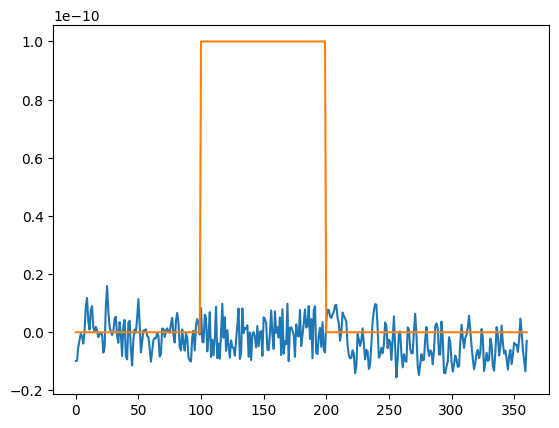

In [27]:
start = 100
dist = 100
X_zeros = np.zeros_like(X)
# X[:, :, start:start+dist] = 1*(2*1e-10*np.random.random((940, 204, dist)) - 1e-10)
# X[:, :, start:start+dist] = 0.
X[:, :, start:start+dist] = 1*(2*1e-11*np.random.random((940, 204, dist)) - 1e-11)
X_zeros[:, :, start:start+dist] += 1e-10*np.ones((940, 204, dist))
X_zeros = X_zeros[0, 0]
plt.plot(X[0, 0])
plt.plot(X_zeros)

In [ ]:
start = 100
dist = 150
X_zeros = np.zeros_like(X)
X[:, :, start:start+dist] = 1*(2*1e-10*np.random.random((940, 204, dist)) - 1e-10)
# X[:, :, start:start+dist] = 0.
# X[:, :, start:start+dist] = 1*(2*1e-11*np.random.random((940, 204, dist)) - 1e-11)
X_zeros[:, :, start:start+dist] += 1e-10*np.ones((940, 204, dist))
X_zeros = X_zeros[0, 0]
plt.plot(X[0, 0])
plt.plot(X_zeros)

In [ ]:
X = X_original.copy()
n_noises = 1
X_zeros = np.zeros_like(X)
for i in range(n_noises):
    start = np.random.randint(X.shape[-1])
    dist = np.random.randint(X.shape[-1] - start)
    X[:, :, start:start+dist] = 1*(2*1e-10*np.random.random((940, 204, dist)) - 1e-10)
    X_zeros[:, :, start:start+dist] += 1e-10*np.ones((940, 204, dist))
X_zeros = X_zeros[0, 0]
plt.plot(X[0, 0])
plt.plot(X_zeros)

## Create dataset

In [28]:
#Specify import options
import_opt = dict(
    savepath='../TFR/',  # path where TFR files will be saved
    out_name='mne_sample_epochs',  # name of TFRecords files
    fs=600,
    input_type='trials',
    target_type='int',
    picks={'meg':'grad'},
    scale=True,  # apply baseline_scaling
    crop_baseline=True,  # remove baseline interval after scaling
    decimate=None,
    scale_interval=(0, 30),  # indices in time axis corresponding to baseline interval
    n_folds=5,  # validation set size set to 20% of all data
    overwrite=True,
    segment=False,
    test_set='holdout'
)


#write TFRecord files and metadata file to disk
meta = mneflow.produce_tfrecords((X, Y), **import_opt)

dataset = mneflow.Dataset(meta, train_batch=100)

importing from tuple
input shapes: X: (940, 204, 361) targets: (940,)
(940,)
Preprocessing:
Scaling to interval 0.0 - 30.0
n: 940
Splitting into: 6 folds x 156
Preprocessed: (940, 1, 331, 204) (940, 1) folds: 6 x 156
Prepocessed sample shape: (1, 331, 204)
Target shape actual/metadata:  (8,) (8,)
Saving TFRecord# 0


## Specify parameters for SimpleNet

In [29]:
lf_params = dict(
    n_latent=16, #number of latent factors
    filter_length=50, #convolutional filter length in time samples
    nonlin = tf.nn.relu,
    padding = 'SAME',
    pooling = 5,#pooling factor
    stride = 5, #stride parameter for pooling layer
    pool_type='max',
    model_path = import_opt['savepath'],
    dropout = .5,
    l1_scope = ["weights"],
    l1=3e-3,
)

## Run SimpleNet

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 692, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 692, 16)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 692, 16)
Setting reg for fc, to l1
Built: fc input: (None, 1, 139, 16)
Input shape: (1, 692, 204)
y_pred: (None, 8)
Initialization complete!
Class weights:  None
Epoch 1/25
100/100 - 8s - loss: 2.0162 - cat_ACC: 0.1907 - val_loss: 1.9144 - val_cat_ACC: 0.2429 - 8s/epoch - 80ms/step
Epoch 2/25
100/100 - 7s - loss: 1.5426 - cat_ACC: 0.4407 - val_loss: 1.3745 - val_cat_ACC: 0.4357 - 7s/epoch - 69ms/step
Epoch 3/25
100/100 - 7s - loss: 0.8597 - cat_ACC: 0.7178 - val_loss: 0.9598 - val_cat_ACC: 0.6500 - 7s/epoch - 69ms/step
Epoch 4/25
100/100 - 7s - loss: 0.4453 - cat_ACC: 0.8579 - val_loss: 0.7804 - val_cat_ACC: 0.6929 - 7s/epoch - 70ms/step
Epoch 5/25
100/100 - 7s - loss: 0.2453 - cat_ACC: 0.9243 - val_loss: 0.6935 - val_cat_ACC: 0.7143 - 7s/epoch - 70ms/step
Epoch 6/25
100/100 - 7s - loss: 0.1394 - 

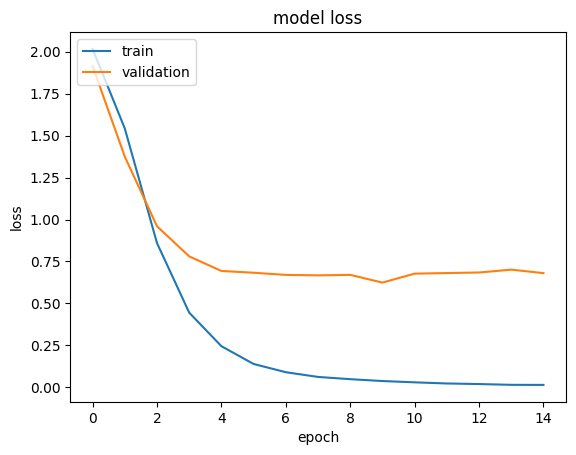

In [20]:
model = SimpleNet(dataset, lf_params)
model.build()
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

## Check accuracy

In [137]:
test_loss, test_acc = model.evaluate(meta['test_paths'])
test_acc

0.10897435992956161

## Try upgraded version

In [138]:
model = SimpleNetA(dataset, lf_params)
model.build()

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 331, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 331, 16)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 331, 16)
Setting reg for fc, to l1
Built: fc input: (None, 1, 1, 16)
Input shape: (1, 331, 204)
y_pred: (None, 8)
Initialization complete!


In [139]:
model = SimpleNetA(dataset, lf_params)
model.build()
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 331, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 331, 16)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 331, 16)
Setting reg for fc, to l1
Built: fc input: (None, 1, 1, 16)
Input shape: (1, 331, 204)
y_pred: (None, 8)
Initialization complete!
Class weights:  None
Epoch 1/25
100/100 - 8s - loss: nan - cat_ACC: 0.1204 - val_loss: nan - val_cat_ACC: 0.1250 - 8s/epoch - 83ms/step
Epoch 2/25
100/100 - 5s - loss: nan - cat_ACC: 0.1215 - val_loss: nan - val_cat_ACC: 0.1250 - 5s/epoch - 46ms/step
Epoch 3/25
100/100 - 4s - loss: nan - cat_ACC: 0.1144 - val_loss: nan - val_cat_ACC: 0.1250 - 4s/epoch - 42ms/step
Epoch 4/25
100/100 - 5s - loss: nan - cat_ACC: 0.1204 - val_loss: nan - val_cat_ACC: 0.1250 - 5s/epoch - 45ms/step
Epoch 5/25


KeyboardInterrupt: 

## Check accuracy

In [23]:
test_loss, test_acc = model.evaluate(meta['test_paths'])
test_acc

0.7371794581413269

## Compute patterns + estimate compression weights

In [24]:
model.compute_patterns()

Computing patterns: No path specified, using validation dataset (Default)
Processing branch 0...	DONE, 692
Processing branch 1...	DONE, 692
Processing branch 2...	DONE, 692
Processing branch 3...	DONE, 692
Processing branch 4...	DONE, 692
Processing branch 5...	DONE, 692
Processing branch 6...	DONE, 692
Processing branch 7...	DONE, 692
Processing branch 8...	DONE, 692
Processing branch 9...	DONE, 692
Processing branch 10...	DONE, 692
Processing branch 11...	DONE, 692
Processing branch 12...	DONE, 692
Processing branch 13...	DONE, 692
Processing branch 14...	DONE, 692
Processing branch 15...	DONE, 692


## Visualize compression weights for a branch. Its shape: n_times x n_downsampled_times

In [55]:
w = model.pool_list[1].weights[0].numpy()

In [ ]:
plt.imshow(w.T, aspect = "auto", origin = "lower")

## Compare with a signal from one of channels

In [ ]:
import scipy as sp

plt.plot(sp.stats.zscore(model.temp_relevance_loss[5]))
plt.plot(sp.stats.zscore(X_zeros[30:])-5)
plt.gca().axes.yaxis.set_visible(False)

In [21]:
sigmoid = lambda x: 1/(1 + np.exp(-x))

In [133]:
time_courses_filtered.shape[0]

16

In [ ]:
order = np.argsort(model.branch_relevance_loss)[::-1]
sorting = order
for i in range(model.specs['n_latent']):
    legend = list()
    time_courses_filtered = model.lat_tcs_filt
    time_courses_env = np.zeros_like(time_courses_filtered)
    kern = np.squeeze(model.envconv.filters.numpy()).T
    for i_comp in range(kern.shape[0]):
            # conv = np.convolve(time_courses_filtered[i_ch, :], kern[i_comp, :], mode="same")
            conv = np.abs(np.convolve(time_courses_filtered[i_comp, :], kern[i_comp, :], mode="same"))
            time_courses_env[i_comp, :] = conv
    time_courses_env = np.squeeze(time_courses_env.reshape(
            [model.specs['n_latent'], -1, model.dataset.h_params['n_t']]
        ))
    time_courses_filtered = np.squeeze(time_courses_filtered.reshape(
            [model.specs['n_latent'], -1, model.dataset.h_params['n_t']]
        ))
    time_courses_env = np.expand_dims(np.transpose(time_courses_env, (1, 2, 0)), (1, -2))

    selected_time_course = np.array(time_courses_env)[:, :, :, :, sorting][:, :, :, :, i]
    selected_time_course_plot = np.squeeze(selected_time_course)
    selected_w =  model.pool_list[sorting[i]].weights[0].numpy()
    selected_temp_relevance_loss = model.temp_relevance_loss[sorting[i]]

    kernel_size = 20
    kernel = np.ones(kernel_size) / kernel_size
    print(order[i], model.branch_relevance_loss[i])
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    data = np.cov(selected_w)

    #evoked
    # ax1.plot(sp.stats.zscore(selected_time_course_plot.mean(0)) - sp.stats.zscore(selected_time_course_plot.mean(0)).min())
    # # data_convolved = np.convolve(selected_w.mean(1), kernel, mode='same')
    # legend.append('component envelope')

    # # sum
    # data = np.cov(selected_w)
    # data_convolved = np.convolve(data.sum(0), kernel, mode='same')
    # ax1.plot(
    #     np.concatenate([
    #         [np.nan for i in range(10)],
    #         sp.stats.zscore(data_convolved[10:-10]),
    #         [np.nan for i in range(10)],
    #     ])
    # )
    # legend.append('cov sum')

    # sum masked
    # window = selected_w.shape[0]//selected_w.shape[1]
    # points = list()
    # # for i in range(0, len(data), window):
    # for i in range(len(data)):
    #     points.append(
    #         np.heaviside(data[i:i+min(window, len(data) - i), i:i+min(window, len(data) - i)], 0).sum()
    #     )
    # points = np.array(points)
    # # data_convolved = np.convolve(interp(points, len(data)), kernel, mode='same')
    # data_convolved = np.convolve(points, kernel, mode='same')
    # ax1.plot(
    #     np.concatenate([
    #         [np.nan for i in range(10)],
    #         sp.stats.zscore(data_convolved[10:-10]),
    #         [np.nan for i in range(10)],
    #     ])
    # )
    # legend.append('cov sum masked')

    #ec
    ec = np.real(eigencentrality(data))
    data_convolved = np.convolve(ec, kernel, mode='same')
    ax1.plot(
        np.concatenate([
            [np.nan for i in range(10)],
            sp.stats.zscore(data_convolved[10:-10]) - sp.stats.zscore(data_convolved[10:-10]).min(),
            [np.nan for i in range(10)],
        ])
    )
    legend.append('eigencentrality')

    #loss
    # ax1.plot(sp.stats.zscore(selected_temp_relevance_loss))
    data_convolved = np.convolve(selected_temp_relevance_loss, kernel, mode='same')
    ax1.plot(
        np.concatenate([
            [np.nan for i in range(10)],
            -sp.stats.zscore(data_convolved[10:-10]) - sp.stats.zscore(data_convolved[10:-10]).min(),
            [np.nan for i in range(10)],
        ])
    )
    legend.append('loss')

    #actual
    ax1.plot(sp.stats.zscore(X_zeros[30:]) - sp.stats.zscore(X_zeros[30:]).min())
    legend.append('noise binary mask')

    ax1.legend(
        legend,
        loc='upper right',
    )
    ax2.imshow(data, aspect='auto')
    ax3.imshow(np.heaviside(data, 0), aspect='auto')
    # ax1.axes.yaxis.set_visible(False)
    # ax1.set_ylim(-4, 4)
    fig.set_size_inches(20, 7)
    plt.show()
    # plt.imshow(np.cov(selected_w))
    # plt.show()

In [ ]:
order = np.argsort(model.branch_relevance_loss)[::-1]
sorting = order
for i in range(model.specs['n_latent']):
    legend = list()
    time_courses_filtered = model.lat_tcs_filt
    time_courses_env = np.zeros_like(time_courses_filtered)
    kern = np.squeeze(model.envconv.filters.numpy()).T
    for i_comp in range(kern.shape[0]):
            # conv = np.convolve(time_courses_filtered[i_ch, :], kern[i_comp, :], mode="same")
            conv = np.abs(np.convolve(time_courses_filtered[i_comp, :], kern[i_comp, :], mode="same"))
            time_courses_env[i_comp, :] = conv
    time_courses_env = np.squeeze(time_courses_env.reshape(
            [model.specs['n_latent'], -1, model.dataset.h_params['n_t']]
        ))
    time_courses_filtered = np.squeeze(time_courses_filtered.reshape(
            [model.specs['n_latent'], -1, model.dataset.h_params['n_t']]
        ))
    time_courses_env = np.expand_dims(np.transpose(time_courses_env, (1, 2, 0)), (1, -2))

    selected_time_course = np.array(time_courses_env)[:, :, :, :, sorting][:, :, :, :, i]
    selected_time_course_plot = np.squeeze(selected_time_course)
    selected_w =  model.pool_list[sorting[i]].weights[0].numpy()
    selected_temp_relevance_loss = model.temp_relevance_loss[sorting[i]]

    kernel_size = 20
    kernel = np.ones(kernel_size) / kernel_size
    print(order[i], model.branch_relevance_loss[i])
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    data = np.cov(selected_w)

    #evoked
    # ax1.plot(sp.stats.zscore(selected_time_course_plot.mean(0)) - sp.stats.zscore(selected_time_course_plot.mean(0)).min())
    # # data_convolved = np.convolve(selected_w.mean(1), kernel, mode='same')
    # legend.append('component envelope')

    # # sum
    # data = np.cov(selected_w)
    # data_convolved = np.convolve(data.sum(0), kernel, mode='same')
    # ax1.plot(
    #     np.concatenate([
    #         [np.nan for i in range(10)],
    #         sp.stats.zscore(data_convolved[10:-10]),
    #         [np.nan for i in range(10)],
    #     ])
    # )
    # legend.append('cov sum')

    # sum masked
    # window = selected_w.shape[0]//selected_w.shape[1]
    # points = list()
    # # for i in range(0, len(data), window):
    # for i in range(len(data)):
    #     points.append(
    #         np.heaviside(data[i:i+min(window, len(data) - i), i:i+min(window, len(data) - i)], 0).sum()
    #     )
    # points = np.array(points)
    # # data_convolved = np.convolve(interp(points, len(data)), kernel, mode='same')
    # data_convolved = np.convolve(points, kernel, mode='same')
    # ax1.plot(
    #     np.concatenate([
    #         [np.nan for i in range(10)],
    #         sp.stats.zscore(data_convolved[10:-10]),
    #         [np.nan for i in range(10)],
    #     ])
    # )
    # legend.append('cov sum masked')

    #ec
    ec = np.real(eigencentrality(data))
    data_convolved = np.convolve(ec, kernel, mode='same')
    ax1.plot(
        np.concatenate([
            [np.nan for i in range(10)],
            sp.stats.zscore(data_convolved[10:-10]) - sp.stats.zscore(data_convolved[10:-10]).min(),
            [np.nan for i in range(10)],
        ])
    )
    legend.append('eigencentrality')

    #loss
    # ax1.plot(sp.stats.zscore(selected_temp_relevance_loss))
    data_convolved = np.convolve(selected_temp_relevance_loss, kernel, mode='same')
    ax1.plot(
        np.concatenate([
            [np.nan for i in range(10)],
            -sp.stats.zscore(data_convolved[10:-10]) - sp.stats.zscore(data_convolved[10:-10]).min(),
            [np.nan for i in range(10)],
        ])
    )
    legend.append('loss')

    #actual
    ax1.plot(sp.stats.zscore(X_zeros[30:]) - sp.stats.zscore(X_zeros[30:]).min())
    legend.append('noise binary mask')

    ax1.legend(
        legend,
        loc='upper right',
    )
    ax2.imshow(data, aspect='auto')
    ax3.imshow(np.heaviside(data, 0), aspect='auto')
    # ax1.axes.yaxis.set_visible(False)
    # ax1.set_ylim(-4, 4)
    fig.set_size_inches(20, 7)
    plt.show()
    # plt.imshow(np.cov(selected_w))
    # plt.show()

## Visualize 1st branch (branch importance estimated according to its loss)

In [ ]:
for i in range(16):
    fig = model.plot_branch(i, epochs.info, params=['input', 'pattern', 'response'])
    plt.show()

In [ ]:
fig = model.plot_branch(4, epochs.info, params=['input', 'pattern', 'response'])

In [ ]:
fig = model.plot_branch(0, epochs.info, params=['input', 'pattern', 'response'])

In [58]:
def compute_patterns(self, data_path=None, *, output='patterns'):
    if not data_path:
        print("Computing patterns: No path specified, using validation dataset (Default)")
        ds = self.dataset.val
    elif isinstance(data_path, str) or isinstance(data_path, (list, tuple)):
        ds = self.dataset._build_dataset(
            data_path,
            split=False,
            test_batch=None,
            repeat=True
        )
    elif isinstance(data_path, mneflow.data.Dataset):
        if hasattr(data_path, 'test'):
            ds = data_path.test
        else:
            ds = data_path.val
    elif isinstance(data_path, tf.data.Dataset):
        ds = data_path
    else:
        raise AttributeError('Specify dataset or data path.')

    X, y = [row for row in ds.take(1)][0]

    self.out_w_flat = self.fin_fc.w.numpy()
    self.out_weights = np.reshape(
        self.out_w_flat,
        [-1, self.dmx.size, self.out_dim]
    )
    self.out_biases = self.fin_fc.b.numpy()
    # self.componentwise_loss(X, y)
    # self.branchwise_loss(X, y)
    # self.tempwise_loss(X, y)

    # compute temporal convolution layer outputs for vis_dics
    tc_out = self.tconv(self.dmx(X)).numpy()

    # compute data covariance
    X = X - tf.reduce_mean(X, axis=-2, keepdims=True)
    X = tf.transpose(X, [3, 0, 1, 2])
    X = tf.reshape(X, [X.shape[0], -1])
    self.dcov = tf.matmul(X, tf.transpose(X))

    # get spatial extraction fiter weights
    demx = self.dmx.w.numpy()

    kern = np.squeeze(self.tconv.filters.numpy()).T
    kern2 = np.squeeze(self.envconv.filters.numpy()).T

    X = X.numpy().T
    if 'patterns' in output:
        if 'old' in output:
            self.patterns = np.dot(self.dcov, demx)
        else:
            patterns = []
            X_filt = np.zeros_like(X)
            for i_comp in range(kern.shape[0]):
                for i_ch in range(X.shape[1]):
                    x = X[:, i_ch]
                    X_filt[:, i_ch] = np.maximum(0, np.convolve(x, kern[i_comp, :], mode="same"))
                if 'temp' in output:
                    X_filt[:, i_ch] = np.maximum(0, np.convolve(X_filt[:, i_ch], kern2[i_comp, :], mode="same"))
                    w = model.pool_list[i_comp].weights[0].numpy()
                    X_filtr = np.reshape(X_filt, (-1, w.shape[0], X_filt.shape[-1])) #epochs, times, channels
                    X_filtr_tf = list()
                    for epoch in X_filtr:
                        X_filtr_tf.append(w.T@epoch)

                    X_filtr_tf = np.array(X_filtr_tf)
                    X_filtr_tf = np.reshape(X_filtr_tf, (X_filtr_tf.shape[0]*X_filtr_tf.shape[1], -1))
                    patterns.append(np.cov(
                        # X_filt.T
                        sigmoid(X_filtr_tf).T
                    ) @ demx[:, i_comp])
                else:
                    patterns.append(np.cov(X_filt.T) @ demx[:, i_comp])
            self.patterns = np.array(patterns).T
            self.lat_tcs_filt = np.dot(demx.T, X_filt.T)
    else:
        self.patterns = demx

    self.lat_tcs = np.dot(demx.T, X.T)

    del X

    #  Temporal conv stuff
    self.filters = kern.T
    self.tc_out = np.squeeze(tc_out)

compute_patterns(model, output='patterns')

Computing patterns: No path specified, using validation dataset (Default)


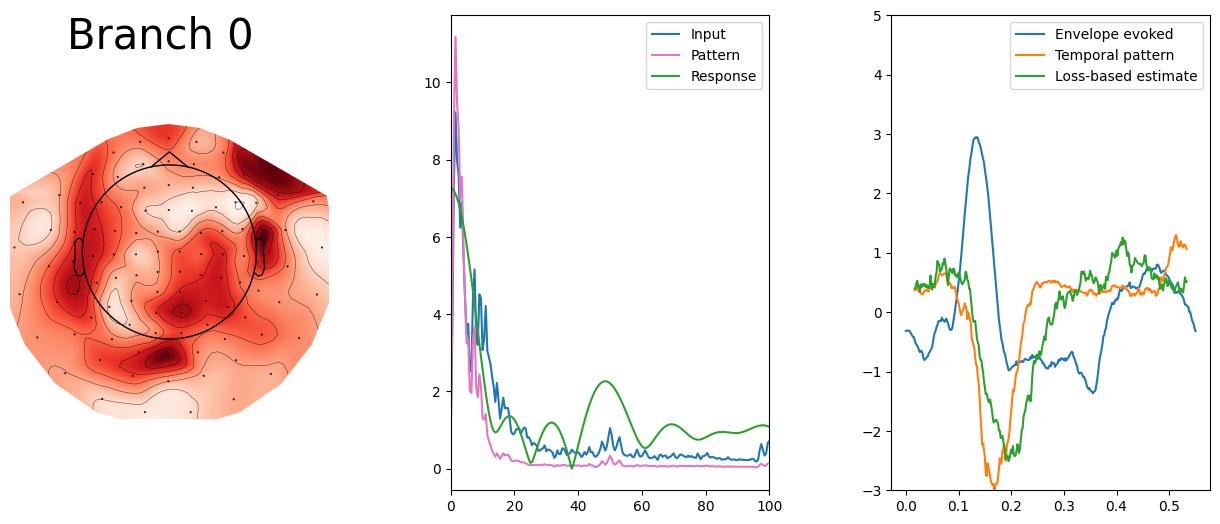

In [59]:
fig = model.plot_branch(0, epochs.info, params=['input', 'pattern', 'response'])

## Playing with loss

In [29]:
X, y = [row for row in model.dataset.val.take(1)][0]

In [18]:
X.shape

TensorShape([131, 1, 331, 204])

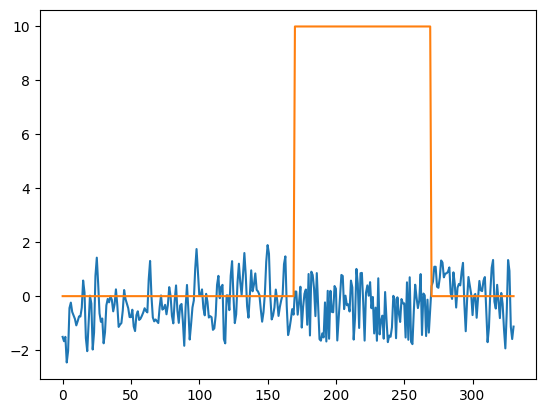

In [30]:
plt.plot(X[0, 0, :, 0])
plt.plot(X_zeros[30:]*10e10)

In [37]:
self = model
model_weights_original = self.km.get_weights().copy()
temp_sel_weights = model_weights_original[3:-2]
base_loss, _ = self.km.evaluate(X, y, verbose=0)


i_latent = 0
tem_sel_w = temp_sel_weights[i_latent]

# i_timepoint = 0
window_size = 1
timelosses = list()
for i_timepoint in range(0, len(tem_sel_w), window_size):
    tem_sel_w_copy = tem_sel_w.copy()
    # tem_sel_w_copy[200:220, :] = 0
    # tem_sel_w_copy[i_timepoint:i_timepoint+min(window_size, len(tem_sel_w) - i_timepoint), :] = 0
    tem_sel_w_copy[:i_timepoint, :] = 0
    tem_sel_w_copy[i_timepoint+min(window_size, len(tem_sel_w) - i_timepoint):, :] = 0
    temp_sel_weights_copy = temp_sel_weights.copy()
    temp_sel_weights_copy[i_latent] = tem_sel_w_copy
    for i in range(len(temp_sel_weights_copy)):
        if i != i_latent:
            temp_sel_weights_copy[i] = np.zeros_like(temp_sel_weights_copy[i])
    model_weights = model_weights_original.copy()
    model_weights[3:-2] = temp_sel_weights_copy
    self.km.set_weights(model_weights)
    loss = self.km.evaluate(X, y, verbose=0)[0]
    self.km.set_weights(model_weights_original)
    timelosses += [loss for _ in range(min(window_size, len(tem_sel_w) - i_timepoint))]
loss

2.1243491172790527

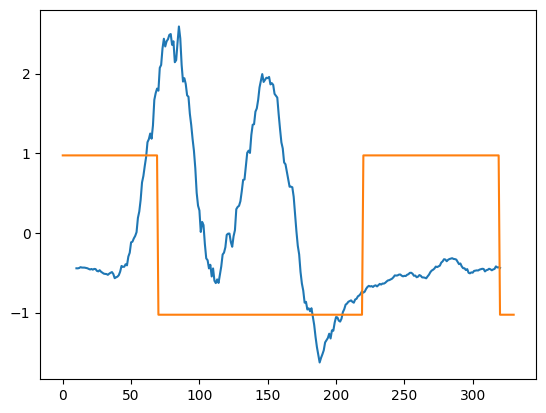

In [39]:
# plt.plot(-np.array(timelosses))
data_convolved = np.convolve(-np.array(timelosses), kernel, mode='same')
plt.plot(
    np.concatenate([
        [np.nan for i in range(10)],
        sp.stats.zscore(data_convolved[10:-10]),
        [np.nan for i in range(10)],
    ])
)
plt.plot(sp.stats.zscore(X_zeros[30:]))

In [67]:
timelosses1 = np.array(timelosses).copy()

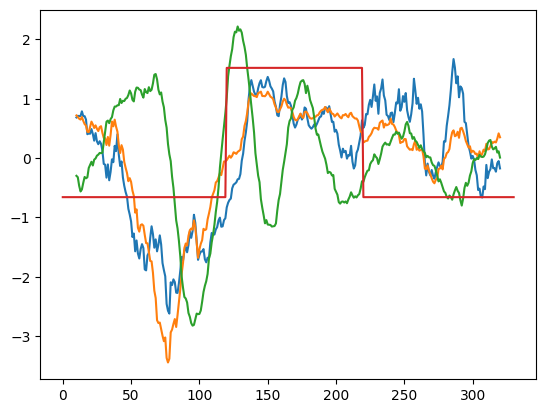

In [69]:
# plt.plot(sp.stats.zscore(timelosses1))
data_convolved = np.convolve(base_loss - timelosses1, kernel, mode='same')
plt.plot(
    np.concatenate([
        [np.nan for i in range(10)],
        sp.stats.zscore(data_convolved[10:-10]),
        [np.nan for i in range(10)],
    ])
)
data_convolved = np.convolve(timelosses1_r, kernel, mode='same')
plt.plot(
    np.concatenate([
        [np.nan for i in range(10)],
        sp.stats.zscore(data_convolved[10:-10]),
        [np.nan for i in range(10)],
    ])
)
# plt.plot(sp.stats.zscore(timelosses5))
# plt.plot(sp.stats.zscore(timelosses10))
# plt.plot(sp.stats.zscore(timelosses10_r))
# plt.plot(sp.stats.zscore(timelosses50))
data_convolved = np.convolve(ec, kernel, mode='same')
plt.plot(
    np.concatenate([
        [np.nan for i in range(10)],
        sp.stats.zscore(data_convolved[10:-10]),
        [np.nan for i in range(10)],
    ])
)
plt.plot(sp.stats.zscore(X_zeros[30:]))

In [347]:
base_loss

1.077439785003662

In [322]:
loss

1.072342038154602

In [34]:
loss

1.3700871467590332

In [ ]:
self = model
model_weights_original = self.km.get_weights().copy()
temp_sel_weights = model_weights_original[6:-2]
base_loss, _ = self.km.evaluate(X, y, verbose=0)
window_size = 5
# window_size = 1
componentslosses = list()
for i_latent, tem_sel_w in enumerate(temp_sel_weights):
    print(f'Processing branch {i_latent}...', end='')
    timelosses = list()
    for i_timepoint in range(0, len(tem_sel_w), window_size):
        tem_sel_w_copy = tem_sel_w.copy()
        tem_sel_w_copy[i_timepoint:i_timepoint+min(window_size, len(tem_sel_w) - i_timepoint), :] = 0
        # tem_sel_w_copy[i_timepoint:i_timepoint+min(window_size, len(tem_sel_w) - i_timepoint), :] = 0
        temp_sel_weights_copy = temp_sel_weights.copy()
        temp_sel_weights_copy[i_latent] = tem_sel_w_copy
        model_weights = model_weights_original.copy()
        model_weights[6:-2] = temp_sel_weights_copy
        self.km.set_weights(model_weights)
        loss = self.km.evaluate(X, y, verbose=0)[0]
        timelosses += [loss for _ in range(min(window_size, len(tem_sel_w) - i_timepoint))]
    componentslosses.append(timelosses)
    print(f'\tDONE, {len(timelosses)}')
self.km.set_weights(model_weights_original)
self.temp_relevance_loss = - np.array(componentslosses) + base_loss